In [1]:
# Standard library imports
from collections import OrderedDict, namedtuple
from functools import partial

# Third-party library imports
from scipy.optimize import minimize
import numpy as np
import sympy as sp
import torch
import cyipopt

# Local application imports
from graph.matrixview import render_incidence
from engine.torchengine import (
    AnalyticalSetSympy, EliminateAnalysisMergeResiduals, EliminateAnalysis,
    FunctionSympy, get_analysis_structure, ElimResidual, ParallelResiduals,
    ipoptsolver
)
from engine.torchdata import (
    load_file, process_expression, process_json, load_vals, perturb,
    generate_optim_functions, print_formatted_table
)

# Set numpy print options
np.set_printoptions(formatter={'float': lambda x: "{:0.2f}".format(x).rstrip('0').rstrip('.')})


### Structure choice

### 1) User defined

In [2]:
disciplines = ['pearl_geom', 'pearl_hydro', 'pearl_mass', 'pearl_prop', 'pearl_power', 'pearl_solar', 'pearl_battery',
'pearl_prob']

### 2) Restructure

In [3]:
disciplines = ['pearl_restructured','pearl_prob']

### Import model

In [3]:
symb_str_mapping = {}
all_analyses = {}
flattened_output = []
equality_constraints_sympy = []
inequality_constraints_sympy = []
for file_name in disciplines:
    data = load_file(file_name)
    equality_constraints_sympy += [
        process_expression(elt, symb_str_mapping) 
        for elt in data.get('equality_constraints',[])]
    inequality_constraints_sympy += [
        process_expression(elt, symb_str_mapping) 
        for elt in data.get('inequality_constraints',[])]
    objective = data.get('objective',None)
    if objective is not None:
        objective = process_expression(objective, symb_str_mapping)
    functional_sets = data.get('functional_sets',[])
    flattened_output += functional_sets
    analysismap, symb_str_mapping = process_json(
        functional_sets, symb_str_mapping)
    all_analyses[file_name] = analysismap

In [4]:
from graph.graphutils import edges_to_Ein_Eout, sources, all_edges, all_variables, flat_graph_formulation
from graph.operators import invert_edges, sort_scc, eqv_to_edges_tree
from presolver.tearing import dir_graph, min_arc_set_assign, min_arc_set

### Load optimization problem

In [5]:
idxrev = {i: elt for i, elt in 
            enumerate(symb_str_mapping.values())}
indices = {elt: torch.tensor([int(i)]) for i, elt in 
            idxrev.items()}
sets ={}
user_groups = {}
# flat sets:
idx = 0
for file_name, analysismap in all_analyses.items():
        user_groups[file_name] = list()
        for _,(analysis,outputvar,residual) in enumerate(analysismap):
                user_groups[file_name].append(idx)
                sets[idx] = AnalyticalSetSympy(analysis, 
                        outputvar=outputvar, indices=indices) 
                idx+=1
equality_constraints = EliminateAnalysisMergeResiduals(functions=[FunctionSympy(expr, indices)
        for expr in equality_constraints_sympy])
inequality_constraints = EliminateAnalysisMergeResiduals(functions=[FunctionSympy(expr, indices)  
        for expr in inequality_constraints_sympy])
objective = FunctionSympy(objective, indices)

## Problem structure

In [6]:
p = load_file('pearl_params')
edges_in = {idx: tuple(str(idxrev[elt.item()]) for elt in s.analysis.structure[0] if str(idxrev[elt.item()]) not in p.keys()) for idx,s in sets.items()}
edges_out = {idx: tuple(str(idxrev[elt.item()]) for elt in s.analysis.structure[1] if str(idxrev[elt.item()]) not in p.keys()) for idx,s in sets.items()}
#edges_in_filter = {key:val for key,val in edges_in.items() if edges_in[key]}
#edges_out_filter = {key:val for key,val in edges_out.items() if edges_in[key]}
edges = (edges_in, edges_out)

## Different ways to define orders

### A) Individual

In [7]:
analyses = {key: s.analysis for key,s in sets.items()}
residuals = {key: s.residual for key,s in sets.items()}

### B) User defined group partition

In [197]:
analyses, residuals = {}, {}
for idx, values in enumerate(user_groups.values()):
    if len(values) > 0:
       analyses[idx] = EliminateAnalysis(analyses=[sets[sidx].analysis for sidx in values])
       residuals[idx] = EliminateAnalysisMergeResiduals(functions=[sets[sidx].residual for sidx in values])

### C) SCC group partition

In [9]:
G = flat_graph_formulation(edges[0], edges[1], {})
order_scc = sort_scc(G)
analyses = {}
residuals = {}
for idx, elt in enumerate(order_scc):
    if len(elt) > 1:
        merge_sets = [sets[f.name] for f in elt]
        R = EliminateAnalysisMergeResiduals(functions=[s.residual for s in merge_sets])
        solvefor = torch.tensor([s.analysis.structure[1] for s in merge_sets])
        E = ElimResidual(R, solvefor, 
                        indices, solvefor_raw=True)
        analyses[idx] = E
        residuals[idx] = E
    else:
        S = sets[next(iter(elt)).name]
        analyses[idx] = S.analysis
        residuals[idx] = S.residual

### 1) Pure AAO/MDF/IDF

In [8]:
order = list(sorted(analyses.keys()))
A = []
B = order

### 2) User defined elimination

In [64]:
order = list(sorted(analyses.keys()))
structure_in, structure_out, full_structure = get_analysis_structure(
    [analyses[idx].structure_full for idx in order])
feedback = {int(elt) for elt in structure_in}.intersection({int(elt) for elt in structure_out})
A = [elt for elt in order if len({elt.item() for elt in analyses[elt].structure[1]
                                  }.intersection(feedback)) == 0]
B = [elt for elt in order if elt not in A]
new_order = A+B

### 3) Minimum feedback elimination

In [193]:
edges_for_solving = invert_edges(*edges)
eqnidxs = list(edges[0].keys())
varidxs = all_variables(*edges_for_solving)
edges_left_right = all_edges(*edges_for_solving)
#dout = {val[0]:key for key,val in edges[1].items()}
dout = {key:val[0] for key,val in edges[1].items()}
cycles, elimset, m = min_arc_set(edges_left_right, dout, varidxs, eqnidxs, timeout=100)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter WLSSecret
Set parameter LicenseID to value 2527862
Academic license 2527862 - for non-commercial use only - registered to no___@mit.edu


In [194]:
edges_new = (edges[0],
             {key:val for key,val in edges[1].items() if key not in elimset})
G = flat_graph_formulation(edges_new[0], edges_new[1], {})
A = [next(iter(elt)).name for elt in sort_scc(G) if next(iter(elt)).name not in elimset]
B = list(elimset)
order = A+B

### Option 1

In [9]:
# Merge residuals only
solvefor = torch.tensor([])
R = EliminateAnalysisMergeResiduals(functions=[residuals[idx] for idx in B])
P = EliminateAnalysis([analyses[idx] for idx in A], [objective,R,equality_constraints,inequality_constraints])
objective_idx,residual_idx,equality_idx,inequality_idx = 0,1,2,3

### Option 2

In [31]:
elimset = [sets[idx].analysis for idx in A]
R = EliminateAnalysisMergeResiduals(elimset, 
                                    [sets[idx].residual for idx in B])
solvefor = torch.tensor([sets[idx].analysis.structure[1] for idx in B])
bnds = [(None, None) for _ in solvefor]
ipsolver = partial(ipoptsolver, bnds_problem=bnds)
S = ElimResidual(R, solvefor, indices, 
                 solver=ipsolver,
                 solvefor_raw=True)
P = EliminateAnalysis([S]+ elimset, [objective,equality_constraints,inequality_constraints])
objective_idx,residual_idx,equality_idx,inequality_idx = 0,None,1,2

### Option 3

In [199]:
solvefor = torch.tensor([])
T = ParallelResiduals([sets[idx].analysis for idx in B], [objective,equality_constraints,inequality_constraints])
P = EliminateAnalysis([sets[idx].analysis for idx in A], [T], flatten=True)
objective_idx,residual_idx,equality_idx,inequality_idx = 0,3,1,2

###  Debug option

In [18]:
R = EliminateAnalysisMergeResiduals(functions=[sets[idx].residual for idx in A])
solvefor = torch.tensor([sets[idx].analysis.structure[1] for idx in A])
bnds = [(None, None) for _ in solvefor]
ipsolver = partial(ipoptsolver, bnds_problem=bnds)
S = ElimResidual(R, solvefor, indices, 
                 solver=ipsolver,
                 solvefor_raw=True)
R2 = EliminateAnalysisMergeResiduals(functions= [sets[idx].residual for idx in B])
P = EliminateAnalysis([S], [objective,R2, equality_constraints,inequality_constraints])
objective_idx,residual_idx,equality_idx,inequality_idx = 0,1,2,3

### Visualize model

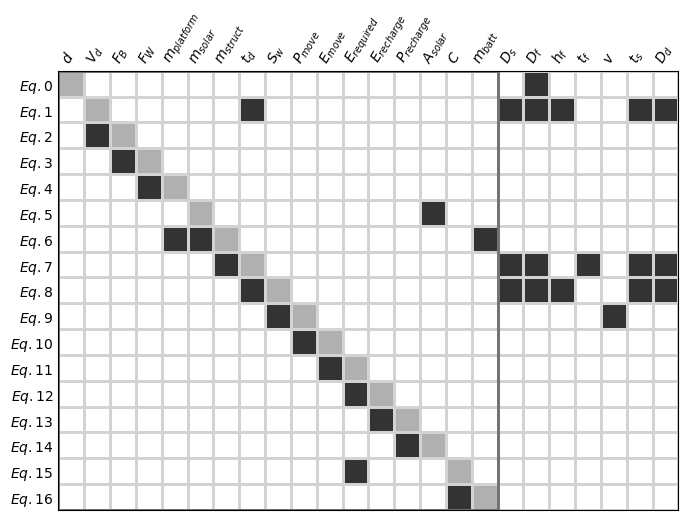

In [10]:
def transform_dict_values(d):
    return {k: tuple(f"{x.split('_')[0]}_{{{x.split('_')[1]}}}" if '_' in x else x for x in v) for k, v in d.items()}
alledges = transform_dict_values(edges[0]), transform_dict_values(edges[1]), {}
tree = (OrderedDict([(elt,1) for elt in order]),{},{})
render_incidence(alledges, tree, rotation=60, hideticks=True, rawvarname=True,
                 dispendcomp=True, figsize=((8,8)), fontsize=10, colsalignleft=True);

## Optimization

In [11]:
pindices = [val for key,val in indices.items() if str(key) in p.keys()]
optim_indices = torch.tensor([elt for elt in P.structure[0] if elt not in solvefor and elt.item() not in pindices])

In [12]:
xp = load_vals('pearl_params', indices=indices, default=1.0)
xs = load_vals('results', indices=indices, x0=xp)
x0 = perturb(xs, 0.2, optim_indices, seed=42)

In [13]:
print_formatted_table([xs, x0], indices, idxrev, subset=optim_indices)

m_platform D_f   d     D_d   D_s   V_d   h_f   t_d   t_s   F_B   F_W   A_solar m_solar m_batt m_struct t_f   S_w   P_move  v     E_move E_required E_recharge P_recharge C     
528.087    1.453 0.073 0.243 0.218 0.528 0.09  0.1   10    5.175 5.175 1.575   15.753  21.825 390.509  0.1   9.02  751.701 0.5   2.706  7.208      7.208      166.852    12.114
577.464    1.151 0.086 0.148 0.161 0.438 0.092 0.094 9.966 5.244 6.342 1.671   16.915  17.64  376.071  0.097 8.248 813.751 0.537 3.865  5.997      6.019      191.655    12.815


In [14]:
P(x0)

[tensor([577.4643], dtype=torch.float64, grad_fn=<IndexBackward0>),
 tensor([-2.8778e-02, -1.3638e-01, -9.5129e-01, -1.0984e+00,  6.9679e+01,
         -2.0174e-01,  6.6839e+01,  3.4142e+00, -1.7823e+00,  3.5541e+01,
         -9.3573e-01,  2.3703e+00, -2.2598e-02, -5.2316e+01,  1.3817e-01,
         -2.7361e+00,  5.1585e+00], dtype=torch.float64, grad_fn=<CatBackward0>),
 tensor([-0.6832], dtype=torch.float64, grad_fn=<CatBackward0>),
 tensor([ 5.0827e-03, -8.7429e-01,  2.8327e-02, -8.1375e+02,  6.3249e-03,
          3.0906e-03], dtype=torch.float64, grad_fn=<CatBackward0>)]

In [15]:
# MAKE SURE TO SET INEQUALITY DIRECTION, it is different for scipy and ipopt
xguess, obj_function, ineq_function, eq_function, dobj, dineq, deq, hobj = generate_optim_functions(P,
    optim_indices, x0, inequality_direction='negative-null', 
    objective=objective_idx, residuals=residual_idx, equalities=equality_idx, inequalities=inequality_idx)
ineqlen = len(ineq_function(xguess))
eqlen = len(eq_function(xguess))
constraints = [{'type': 'eq', 'fun': eq_function, 'jac': deq}] if eqlen >= 1 else []
constraints.append({'type': 'ineq', 'fun': ineq_function, 'jac': dineq}) if ineqlen >= 1 else []

bounds = {
    'D_f': (0.1,10),
    'D_d': (0.1,10),
    'D_s': (0.1,10),
    't_s': (0.1,10),
    't_d': (0.1,10),
    't_f': (0.1,10),
    'v': (0.5,None)
}
bnds_problem = [bounds.get(str(idxrev[elt.item()]), (0, None)) for elt in optim_indices]

In [16]:
# Debug derivatives
# eps = 1e-6
# (ineq_function(xguess+eps*np.eye(len(xguess))[0])-ineq_function(xguess))/eps

In [17]:
[(idxrev[elt.item()],xguess[idx]) for idx,elt in enumerate(optim_indices)]

[(m_platform, 577.4643257859351),
 (D_f, 1.1508062496585665),
 (d, 0.08631832782410749),
 (D_d, 0.14789823803043753),
 (D_s, 0.16143546250642557),
 (V_d, 0.43799087345340254),
 (h_f, 0.092301128285451),
 (t_d, 0.09367513878664467),
 (t_s, 9.966397784344789),
 (F_B, 5.243599565526475),
 (F_W, 6.342006444256304),
 (A_solar, 1.6713071948777336),
 (m_solar, 16.91481690359616),
 (m_batt, 17.639843647738008),
 (m_struct, 376.0706329659263),
 (t_f, 0.09690940067078734),
 (S_w, 8.24767534859529),
 (P_move, 813.7514552363706),
 (v, 0.5365443957066831),
 (E_move, 3.8652369444513064),
 (E_required, 5.996850477431071),
 (E_recharge, 6.01944800965025),
 (P_recharge, 191.65515975591285),
 (C, 12.814823569772605)]

In [18]:
eq_function(xguess).numpy(), ineq_function(xguess).numpy(), obj_function(xguess)

(array([-0.68, -0.03, -0.14, -0.95, -1.1, 69.68, -0.2, 66.84, 3.41, -1.78,
        35.54, -0.94, 2.37, -0.02, -52.32, 0.14, -2.74, 5.16]),
 array([0.01, -0.87, 0.03, -813.75, 0.01, 0]),
 577.4643257859351)

In [19]:
# dobj(xguess), dineq(xguess), deq(xguess)

In [20]:
# np.round(np.linalg.cond(dobj(xguess)),3)

### Solver: IPOPT

In [21]:
def all_constraints(x):
    return np.concatenate([ineq_function(x), eq_function(x)])

def all_constraints_jac(x):
    if eqlen == 0:
        return dineq(x)
    return np.concatenate([dineq(x), deq(x)], axis=0)

OptProblem = namedtuple('OptProblem', ['objective', 'constraints', 'gradient', 'jacobian', 'intermediate'])

lb,ub = zip(*bnds_problem)
cl = np.concatenate([-np.inf*np.ones(ineqlen), np.zeros(eqlen)])
cu = np.concatenate([np.zeros(ineqlen), np.zeros(eqlen)])

storeiter = [0]

def logiter(alg_mod, iter_count, obj_value, inf_pr, inf_du, mu, d_norm, regularization_size, alpha_du, alpha_pr, ls_trials):
    storeiter[0] = iter_count

# define the problem
probinfo = OptProblem(obj_function, all_constraints, dobj, all_constraints_jac, logiter)

prob = cyipopt.Problem(n=len(xguess), m=len(cu), lb=lb, ub=ub, cl=cl, cu=cu, 
                       problem_obj=probinfo)
prob.add_option('max_iter', 8000)
#prob.add_option('acceptable_tol', 1e-6)

In [22]:
xsol, optinfo = prob.solve(xguess)

In [23]:
eq_function(xsol).numpy(), ineq_function(xsol).numpy(), obj_function(xsol)

(array([-0, -0, 0, -0, 0, 0, 0, -0, 0, -0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, -1.09, 0, -751.7, 0, 0]),
 528.0871870858011)

In [24]:
Aelim = EliminateAnalysis([analyses[idx] for idx in A])
yout = Aelim(x0)

In [25]:
residuals[6](yout)

tensor([-5.6843e-14], dtype=torch.float64, grad_fn=<SubBackward0>)

In [27]:
nonpindices = torch.tensor([elt for elt in indices.values() if elt.item() not in pindices])

In [28]:
print_formatted_table([x0, analyses[5](x0)], indices, idxrev, subset=nonpindices)

A_solar D_f   d     D_d   D_s   h_f  t_d t_s V_d   F_B   F_W   m_platform m_solar m_batt m_struct t_f S_w  v   P_move  E_move E_required E_recharge P_recharge C     
1.575   1.453 0.073 0.243 0.218 0.09 0.1 10  0.528 5.175 5.175 528.087    15.753  21.825 390.509  0.1 9.02 0.5 751.701 2.706  7.208      7.208      166.852    12.114
1.575   1.453 0.073 0.243 0.218 0.09 0.1 10  0.528 5.175 5.175 528.087    15.753  21.825 390.509  0.1 9.02 0.5 751.701 2.706  7.208      7.208      166.852    12.114


In [29]:
storeiter

[285]

In [30]:
optinfo

{'x': array([528.09, 1.45, 0.07, 0.24, 0.22, 0.53, 0.09, 0.1, 10, 5.18, 5.18,
        1.58, 15.75, 21.83, 390.51, 0.1, 9.02, 751.7, 0.5, 2.71, 7.21,
        7.21, 166.85, 12.11]),
 'g': array([0, -1.09, 0, -751.7, 0, 0, -0, -0, 0, -0, 0, 0, 0, -0, 0, -0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 'obj_val': 528.0871870858011,
 'mult_g': array([4695.03, 0, 327.29, 0, 176.81, 121.47, -21.54, -0, -2849.64,
        -290.78, -290.78, -2.85, 3.85, -3.85, -480.21, 6.63, 0.08, 22.11,
        22.11, 13.12, 0.57, 60.03, 5.35, 3.85]),
 'mult_x_L': array([0, 0, 0, 0, 0, 0, 0, 176.81, 0, 0, 0, 0, 0, 0, 0, 121.47, 0, 0,
        358.94, 0, 0, 0, 0, 0]),
 'mult_x_U': array([0, 0, 0, 0, 0, 0, 0, 0, 1.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]),
 'status': 0,
 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}

### Solver: SLQSP

In [101]:
trace = []
def trace_points(xk):
    trace.append(np.copy(xk))

In [102]:
# # Solve the optimization problem
xsol = minimize(obj_function, xguess, bounds=bnds_problem, jac=dobj, constraints=constraints, options={'maxiter': 500, 'disp':True}, method='SLSQP', callback=trace_points)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 532.7571750985691
            Iterations: 10
            Function evaluations: 6
            Gradient evaluations: 6


In [585]:
tidx = 2
ineq_function(trace[tidx]).numpy(), eq_function(trace[tidx]).numpy(), obj_function(trace[tidx])

(array([0, 0, 0, 720.03, -0]), array([], dtype=float32), 363.47854716583134)

In [586]:
dineq(trace[tidx]), dobj(trace[tidx])

(array([[0, 0, 0, -1, 0, 0, 0, 0.9, 0],
        [0, 0.9, -1, 0, 0, 0, 0, 0, 0],
        [0.9, 0, -1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [-0.84, 0.1, 13.44, 0.59, 0.14, -0.13, -0.01, -0.41, 0]]),
 array([0, 37.77, 3929.8, 69.65, 41.78, -5.88, -0.59, -18.06, 0]))

In [588]:
xsol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 363.5835135402174
       x: [ 2.363e-01  2.363e-01  2.127e-01  9.000e-02  1.000e+01
            2.658e-10  2.658e-11  1.000e-01  7.200e+02]
     nit: 13
     jac: [ 3.162e-05  3.777e+01  3.930e+03  6.966e+01  4.179e+01
           -5.882e+00 -5.882e-01 -1.806e+01  0.000e+00]
    nfev: 45
    njev: 9

In [589]:
xsol.x

array([0.24, 0.24, 0.21, 0.09, 10, 0, 0, 0.1, 720.03])

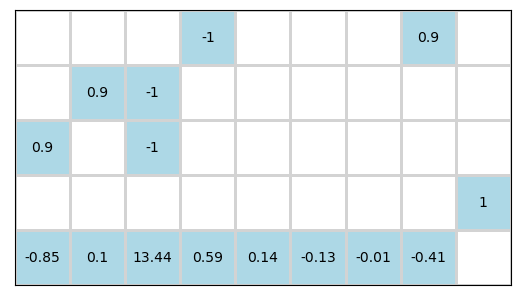

In [590]:
Am = dineq(xsol.x)
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


# Create a figure and axis
fig, ax = plt.subplots()

# Create a custom color map
cmap = ListedColormap(['white', 'lightblue'])

# Flip A upside down
A_flipped = np.flipud(Am)

# Use imshow to create a binary color map
cax = ax.pcolormesh(np.where(A_flipped != 0, 1, 0), cmap=cmap, edgecolors='lightgray', linewidth=1)

# Make cells square
ax.set_aspect('equal')

# Get the number of cells in x and y directions
num_cells_x = Am.shape[1]
num_cells_y = Am.shape[0]

# Add text at the center of the cells
for i in range(num_cells_y):
    for j in range(num_cells_x):
        if Am[i, j] != 0:
            ax.text(j+0.5, num_cells_y-i-0.5, "{:0.2f}".format(Am[i,j]).rstrip('0').rstrip('.'), ha='center', va='center')
            
ax.set_xticklabels([])
ax.set_yticklabels([])

# Optionally, remove the ticks as well
ax.set_xticks([])
ax.set_yticks([])

# Show the plot
plt.show()

In [43]:
equality_constraints(x0).detach().numpy(), inequality_constraints(x0).detach().numpy()

(array([-0]), array([0, -1.09, 0, -751.7, 0, 0]))

In [44]:
optim_indices

tensor([ 4,  1,  5, 17, 28,  7,  8])

In [45]:
P(x0)

[tensor([528.0872], dtype=torch.float64, grad_fn=<IndexBackward0>),
 tensor([]),
 tensor([2.2204e-16], dtype=torch.float64, grad_fn=<CatBackward0>),
 tensor([ 9.9996e-09, -1.0894e+00,  9.9949e-09, -7.5170e+02,  9.9906e-09,
          9.9931e-09], dtype=torch.float64, grad_fn=<CatBackward0>)]

## Check results

In [98]:
Aelim = EliminateAnalysis([analyses[idx] for idx in A])
yout = Aelim(x0)

In [164]:
nonpindices = torch.tensor([elt for elt in indices.values() if elt.item() not in pindices])

In [100]:
print_formatted_table([yout, x0], indices, idxrev, subset=nonpindices)

A_solar  D_f   d        D_d   D_s h_f   t_d   t_s   V_d   F_B   F_W   m_platform m_solar m_batt    m_struct  t_f   S_w   v   P_move  E_move E_required E_recharge P_recharge C     
9.21e-03 0.111 5.56e-03 0.236 0.1 0.449 0.616 8.747 0.1   0.981 0.981 528.087    0.092   -9.99e-09 -9.99e-09 2.351 3.444 0.5 287.003 1.033  5.535      7.208      166.852    12.114
9.21e-03 0.111 0.073    0.236 0.1 0.449 0.616 8.747 0.528 0.981 5.175 528.087    0.092   -9.99e-09 -9.99e-09 2.351 9.02  0.5 819.634 2.706  7.208      7.208      166.852    12.114


## Save results

In [33]:
results = {str(idxrev[elt.item()]): yout[elt].item() for elt in nonpindices}

In [228]:
name = 'results.json'
json_string = json.dumps(results, indent=4)
with open('../applications/data/{}'.format(name), 'w') as file:
    file.write(json_string)


## Debugging result

In [34]:
yout[indices[sp.Symbol("P_comms")]]

tensor([50.], dtype=torch.float64, grad_fn=<IndexBackward0>)